In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import ResNet50, DenseNet201, MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset/test_train_3.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_train_3/aptos/training_aug/class_0/ac17cc18a994.png  
  inflating: __MACOSX/test_train_3/aptos/training_aug/class_0/._ac17cc18a994.png  
  inflating: test_train_3/aptos/training_aug/class_0/4eabad7948cf.png  
  inflating: __MACOSX/test_train_3/aptos/training_aug/class_0/._4eabad7948cf.png  
  inflating: test_train_3/aptos/training_aug/class_0/b8e20c076b03.png  
  inflating: __MACOSX/test_train_3/aptos/training_aug/class_0/._b8e20c076b03.png  
  inflating: test_train_3/aptos/training_aug/class_0/7269a1d84a57.png  
  inflating: __MACOSX/test_train_3/aptos/training_aug/class_0/._7269a1d84a57.png  
  inflating: test_train_3/aptos/training_aug/class_0/4dd14c380696.png  
  inflating: __MACOSX/test_train_3/aptos/training_aug/class_0/._4dd14c380696.png  
  inflating: test_train_3/aptos/training_aug/class_0/a627eb8c08c5.png  
  inflating: __MACOSX/test_train_3/aptos/training_aug/class_0/._a627eb8c08c5.png  
  inflating: test_t

In [ ]:
# Paths to datasets
aptos_train_dir = '/content/test_train_3/aptos/training_aug'
aptos_test_dir = '/content/test_train_3/aptos/testing'

drc_train_dir = '/content/test_train_3/drc/training_aug'
drc_test_dir = '/content/test_train_3/drc/testing'

In [ ]:
# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [ ]:
# Helper function to load dataset
def load_dataset(directory, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        label_mode="int",  # Labels are integers (0–4)
        image_size=image_size,
        batch_size=batch_size,
        shuffle=shuffle
    )

# Load individual datasets
aptos_train = load_dataset(aptos_train_dir)
drc_train = load_dataset(drc_train_dir)

aptos_test = load_dataset(aptos_test_dir, shuffle=False)
drc_test = load_dataset(drc_test_dir, shuffle=False)

# Combine datasets
combined_train_dataset = aptos_train.concatenate(drc_train)
combined_test_dataset = aptos_test.concatenate(drc_test)

# Get class names
class_names = aptos_train.class_names
print("Class Names:", class_names)

Found 7220 files belonging to 5 classes.
Found 103240 files belonging to 5 classes.
Found 733 files belonging to 5 classes.
Found 7027 files belonging to 5 classes.
Class Names: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']


In [ ]:
# Function to build the ResNet50 model
def build_resnet50_model():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base layers

    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation="softmax")
    ])
    return model


# Build and compile ResNet50 model
resnet_model = build_resnet50_model()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss="sparse_categorical_crossentropy",
                     metrics=["accuracy"])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


NameError: name 'class_names' is not defined

In [ ]:
# Add a callback to stop training early
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = resnet_model.fit(
    combined_train_dataset,
    epochs=EPOCHS,
    validation_data=combined_test_dataset,
    callbacks=[early_stopping]
    )

# Save the trained model
resnet_model.save('resnet_model_3.h5')

Epoch 1/50
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 102s 25ms/step - accuracy: 0.4421 - loss: 1.3172 - val_accuracy: 0.5274 - val_loss: 1.1631
Epoch 2/50
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.5669 - loss: 1.0591 - val_accuracy: 0.6019 - val_loss: 1.0190
Epoch 3/50
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.6312 - loss: 0.9246 - val_accuracy: 0.5988 - val_loss: 1.0185
Epoch 4/50
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.6721 - loss: 0.8341 - val_accuracy: 0.6095 - val_loss: 1.0051
Epoch 5/50
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.7023 - loss: 0.7657 - val_accuracy: 0.6057 - val_loss: 0.9981
Epoch 6/50
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.7291 - loss: 0.7070 - val_accuracy: 0.6082 - val_loss: 1.0048
Epoch 7/50
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.7504 - loss: 0.6610 - val_accuracy: 0.6183 - val_loss: 0.9811
Epoch 8/50
3453/3453 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - accuracy: 0.7669 

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
resnet_model = load_model('resnet_model_3.h5')
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,367 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
resnet_group1_model = load_model('resnet50_group1.h5')
resnet_group1_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,341 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# This will build the metrics and remove the warning
resnet_model.evaluate(combined_test_dataset)

243/243 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.6812 - loss: 0.8601


[0.9655293226242065, 0.6449742317199707]

In [ ]:
# Evaluate the model
loss, accuracy = resnet_model.evaluate(combined_test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6812 - loss: 0.8601
Test Loss: 0.9655
Test Accuracy: 0.6450


In [ ]:
# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in combined_test_dataset:
    preds = resnet_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Print the full report
print(classification_report(y_true, y_pred, target_names=class_names))

# Extract overall metrics
overall_precision = report['weighted avg']['precision']
overall_recall = report['weighted avg']['recall']
overall_f1 = report['weighted avg']['f1-score']

print(f"\nOverall Precision (Weighted Avg): {overall_precision:.4f}")
print(f"Overall Recall    (Weighted Avg): {overall_recall:.4f}")
print(f"Overall F1-Score  (Weighted Avg): {overall_f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━

243/243 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step


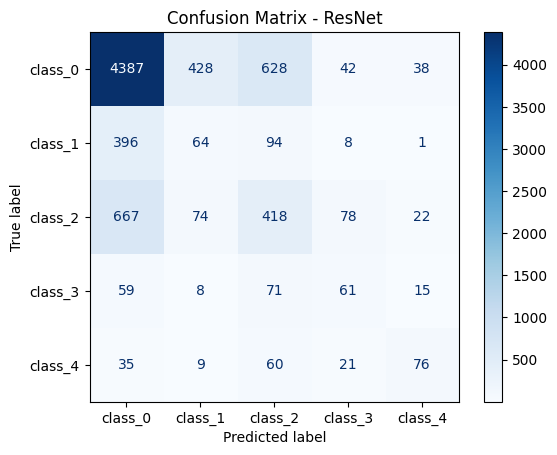

In [ ]:
# Confusion Matrix
y_true = np.concatenate([y for _, y in combined_test_dataset])
y_pred = np.argmax(resnet_model.predict(combined_test_dataset), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - ResNet')
plt.show()

In [ ]:
# Step 1: Get predictions and true labels
y_true = []
y_pred = []

for images, labels in combined_test_dataset:
    preds = resnet_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Step 2: Relabel for grouping
def relabel_grouped(y):
    grouped = []
    for label in y:
        if label in [0, 1, 2]:
            grouped.append(0)  # Group 1
        elif label == 3:
            grouped.append(1)  # Class 3
        elif label == 4:
            grouped.append(2)  # Class 4
    return grouped

grouped_y_true = relabel_grouped(y_true)
grouped_y_pred = relabel_grouped(y_pred)

# Step 3: New class names
grouped_class_names = ['Group 1 (Class 0/1/2)', 'Class 3', 'Class 4']

# Step 4: Classification report
grouped_report = classification_report(grouped_y_true, grouped_y_pred, target_names=grouped_class_names, output_dict=True)

# Step 5: Print full grouped report
print(classification_report(grouped_y_true, grouped_y_pred, target_names=grouped_class_names))

# Step 6: Extract and print overall metrics
overall_precision = grouped_report['weighted avg']['precision']
overall_recall = grouped_report['weighted avg']['recall']
overall_f1 = grouped_report['weighted avg']['f1-score']

print(f"\nGrouped Overall Precision (Weighted Avg): {overall_precision:.4f}")
print(f"Grouped Overall Recall    (Weighted Avg): {overall_recall:.4f}")
print(f"Grouped Overall F1-Score  (Weighted Avg): {overall_f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

In [ ]:
!unzip /content/drive/MyDrive/Dataset/test_train_3_1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_train_3_1/aptos/training_aug/class_0/c57c164bca05.png  
  inflating: __MACOSX/test_train_3_1/aptos/training_aug/class_0/._c57c164bca05.png  
  inflating: test_train_3_1/aptos/training_aug/class_0/780be525036d.png  
  inflating: __MACOSX/test_train_3_1/aptos/training_aug/class_0/._780be525036d.png  
  inflating: test_train_3_1/aptos/training_aug/class_0/8d4ff745a409.png  
  inflating: __MACOSX/test_train_3_1/aptos/training_aug/class_0/._8d4ff745a409.png  
  inflating: test_train_3_1/aptos/training_aug/class_0/8e76054f0831.png  
  inflating: __MACOSX/test_train_3_1/aptos/training_aug/class_0/._8e76054f0831.png  
  inflating: test_train_3_1/aptos/training_aug/class_0/7c2e852171c0.png  
  inflating: __MACOSX/test_train_3_1/aptos/training_aug/class_0/._7c2e852171c0.png  
  inflating: test_train_3_1/aptos/training_aug/class_0/525d0dd8dc45.png  
  inflating: __MACOSX/test_train_3_1/aptos/training_aug/class_0/._525d0dd8dc45.p

In [ ]:
# Paths to Group 1 (class_0, class_1, class_2) datasets
group1_aptos_train_dir = '/content/test_train_3_1/aptos/training_aug'
group1_aptos_test_dir = '/content/test_train_3_1/aptos/testing'

group1_drc_train_dir = '/content/test_train_3_1/drc/training_aug'
group1_drc_test_dir = '/content/test_train_3_1/drc/testing'

In [ ]:
# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [ ]:
# Helper function to load dataset
def load_dataset(directory, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        label_mode="int",  # Labels are integers: 0, 1, 2
        image_size=image_size,
        batch_size=batch_size,
        shuffle=shuffle
    )

# Load Group 1 datasets separately
group1_aptos_train = load_dataset(group1_aptos_train_dir)
group1_drc_train = load_dataset(group1_drc_train_dir)

group1_aptos_test = load_dataset(group1_aptos_test_dir, shuffle=False)
group1_drc_test = load_dataset(group1_drc_test_dir, shuffle=False)

# Combine Group 1 datasets
group1_train_dataset = group1_aptos_train.concatenate(group1_drc_train)
group1_test_dataset = group1_aptos_test.concatenate(group1_drc_test)

# Get class names (should be ['class_0', 'class_1', 'class_2'])
group1_class_names = group1_aptos_train.class_names
print("Group 1 Class Names:", group1_class_names)

Found 4332 files belonging to 3 classes.
Found 61944 files belonging to 3 classes.
Found 635 files belonging to 3 classes.
Found 6710 files belonging to 3 classes.
Group 1 Class Names: ['class_0', 'class_1', 'class_2']


In [ ]:
# Build DenseNet201 model
def build_densenet201_group1_model():
    base_model = DenseNet201(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze backbone

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')  # Group 1 has 3 classes: 0, 1, 2
    ])
    return model

In [ ]:
densenet_model = build_densenet201_group1_model()
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"])

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add a callback to stop training early
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = densenet_model.fit(
    group1_train_dataset,
    epochs=50,
    validation_data=group1_test_dataset,
    callbacks=[early_stopping]
)

# Save model
densenet_model.save('densenet201_group1.h5')

Epoch 1/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 219s 84ms/step - accuracy: 0.4212 - loss: 1.5590 - val_accuracy: 0.5161 - val_loss: 1.0631
Epoch 2/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 70s 34ms/step - accuracy: 0.4951 - loss: 0.9915 - val_accuracy: 0.5416 - val_loss: 1.0136
Epoch 3/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.5273 - loss: 0.9473 - val_accuracy: 0.5284 - val_loss: 1.0471
Epoch 4/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.5434 - loss: 0.9253 - val_accuracy: 0.5819 - val_loss: 0.9529
Epoch 5/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.5584 - loss: 0.8962 - val_accuracy: 0.5660 - val_loss: 0.9766
Epoch 6/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 70s 34ms/step - accuracy: 0.5737 - loss: 0.8774 - val_accuracy: 0.5985 - val_loss: 0.9373
Epoch 7/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.5836 - loss: 0.8627 - val_accuracy: 0.5965 - val_loss: 0.9384
Epoch 8/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.5915 

In [ ]:
def cascaded_predict_group1_only(resnet_model, densenet_model, test_dataset):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        # Stage 1: ResNet prediction (full set)
        resnet_preds = resnet_model.predict(images)
        resnet_pred_classes = np.argmax(resnet_preds, axis=1)

        labels_np = labels.numpy()

        # Select only samples predicted as Group 1 by ResNet
        group1_indices = np.where(np.isin(resnet_pred_classes, [0, 1, 2]))[0]

        if len(group1_indices) == 0:
            continue  # No Group 1 predicted samples in this batch

        group1_images = tf.gather(images, group1_indices)
        group1_true_labels = labels_np[group1_indices]

        # Stage 2: DenseNet refines Group 1
        densenet_preds = densenet_model.predict(group1_images)
        densenet_pred_classes = np.argmax(densenet_preds, axis=1)

        y_true.extend(group1_true_labels)
        y_pred.extend(densenet_pred_classes)

    return np.array(y_true), np.array(y_pred)

# Run cascaded prediction (only on samples predicted as Group 1 by ResNet)
y_true_cascaded_g1, y_pred_cascaded_g1 = cascaded_predict_group1_only(resnet_model, densenet_model, combined_test_dataset)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

In [ ]:
# Generate report as dictionary (filtered to labels 0, 1, 2 only)
group1_report = classification_report(
    y_true_cascaded_g1,
    y_pred_cascaded_g1,
    labels=[0, 1, 2],
    target_names=group1_class_names,
    output_dict=True
)

# Print full report
print("\n--- Classification Report (Group 1 Only, Cascaded) ---")
print(classification_report(
    y_true_cascaded_g1,
    y_pred_cascaded_g1,
    labels=[0, 1, 2],
    target_names=group1_class_names
))

# Step 6: Extract and print weighted average metrics
overall_precision = group1_report['weighted avg']['precision']
overall_recall = group1_report['weighted avg']['recall']
overall_f1 = group1_report['weighted avg']['f1-score']

print(f"\nGroup 1 Overall Precision (Weighted Avg): {overall_precision:.4f}")
print(f"Group 1 Overall Recall    (Weighted Avg): {overall_recall:.4f}")
print(f"Group 1 Overall F1-Score  (Weighted Avg): {overall_f1:.4f}")


--- Classification Report (Group 1 Only, Cascaded) ---
              precision    recall  f1-score   support

     class_0       0.78      0.77      0.77      5443
     class_1       0.13      0.16      0.15       554
     class_2       0.24      0.27      0.25      1159

   micro avg       0.62      0.64      0.63      7156
   macro avg       0.38      0.40      0.39      7156
weighted avg       0.64      0.64      0.64      7156


Group 1 Overall Precision (Weighted Avg): 0.6409
Group 1 Overall Recall    (Weighted Avg): 0.6423
Group 1 Overall F1-Score  (Weighted Avg): 0.6412


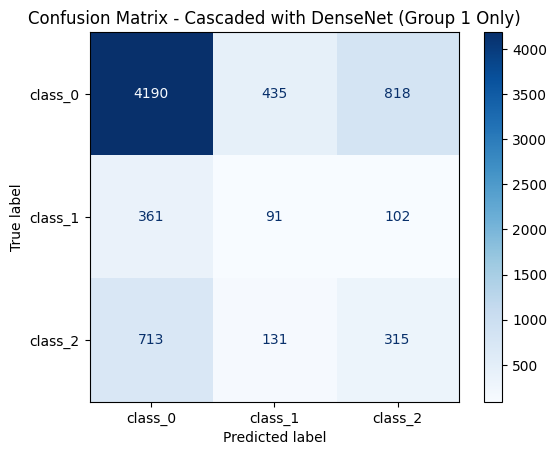

In [ ]:
# Confusion matrix (only for class_0, class_1, class_2)
cm = confusion_matrix(
    y_true_cascaded_g1,
    y_pred_cascaded_g1,
    labels=[0, 1, 2]  # Ensure only Group 1 classes are included
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=group1_class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Cascaded with DenseNet (Group 1 Only)')
plt.show()

In [ ]:
def AlexNet(input_shape=(224, 224, 3), num_classes=3):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(96, kernel_size=11, strides=4, activation='relu', kernel_initializer='he_normal')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=output)
    return model

# Build and compile AlexNet for Group 1
alexnet_model = AlexNet(input_shape=(224, 224, 3), num_classes=3)
alexnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = alexnet_model.fit(
    group1_train_dataset,
    epochs=50,
    validation_data=group1_test_dataset,
    callbacks=[early_stopping]
)

alexnet_model.save("alexnet_group1.h5")

Epoch 1/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.5564 - loss: 1.0720 - val_accuracy: 0.7465 - val_loss: 0.7368
Epoch 2/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.6574 - loss: 0.6916 - val_accuracy: 0.7519 - val_loss: 0.7072
Epoch 3/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.6854 - loss: 0.6676 - val_accuracy: 0.7589 - val_loss: 0.6917
Epoch 4/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7189 - loss: 0.6277 - val_accuracy: 0.7609 - val_loss: 0.6851
Epoch 5/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7717 - loss: 0.5538 - val_accuracy: 0.7612 - val_loss: 0.6971
Epoch 6/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8147 - loss: 0.4731 - val_accuracy: 0.7597 - val_loss: 0.6910
Epoch 7/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8367 - loss: 0.4190 - val_accuracy: 0.7676 - val_loss: 0.6873
Epoch 8/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8525 -

In [ ]:
def cascaded_predict_group1_alexnet(resnet_model, alexnet_model, test_dataset):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        resnet_preds = resnet_model.predict(images)
        resnet_pred_classes = np.argmax(resnet_preds, axis=1)

        labels_np = labels.numpy()
        group1_indices = np.where(np.isin(resnet_pred_classes, [0, 1, 2]))[0]

        if len(group1_indices) == 0:
            continue

        group1_images = tf.gather(images, group1_indices)
        group1_true_labels = labels_np[group1_indices]

        # Predict using AlexNet for Group 1
        alexnet_preds = alexnet_model.predict(group1_images)
        alexnet_pred_classes = np.argmax(alexnet_preds, axis=1)

        y_true.extend(group1_true_labels)
        y_pred.extend(alexnet_pred_classes)

    return np.array(y_true), np.array(y_pred)

# Run cascaded prediction
y_true_alexnet_g1, y_pred_alexnet_g1 = cascaded_predict_group1_alexnet(resnet_model, alexnet_model, combined_test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [ ]:
# Report
group1_report = classification_report(
    y_true_alexnet_g1,
    y_pred_alexnet_g1,
    labels=[0, 1, 2],
    target_names=group1_class_names,
    output_dict=True
)

print("\n--- Classification Report (Group 1 Only, ResNet → AlexNet) ---")
print(classification_report(
    y_true_alexnet_g1,
    y_pred_alexnet_g1,
    labels=[0, 1, 2],
    target_names=group1_class_names
))

# Metrics summary
overall_precision = group1_report['weighted avg']['precision']
overall_recall = group1_report['weighted avg']['recall']
overall_f1 = group1_report['weighted avg']['f1-score']

print(f"\nGroup 1 Overall Precision (Weighted Avg): {overall_precision:.4f}")
print(f"Group 1 Overall Recall    (Weighted Avg): {overall_recall:.4f}")
print(f"Group 1 Overall F1-Score  (Weighted Avg): {overall_f1:.4f}")



--- Classification Report (Group 1 Only, ResNet → AlexNet) ---
              precision    recall  f1-score   support

     class_0       0.75      1.00      0.86      5443
     class_1       0.28      0.06      0.10       554
     class_2       0.61      0.04      0.07      1159

   micro avg       0.74      0.77      0.76      7156
   macro avg       0.55      0.37      0.34      7156
weighted avg       0.69      0.77      0.67      7156


Group 1 Overall Precision (Weighted Avg): 0.6931
Group 1 Overall Recall    (Weighted Avg): 0.7684
Group 1 Overall F1-Score  (Weighted Avg): 0.6717


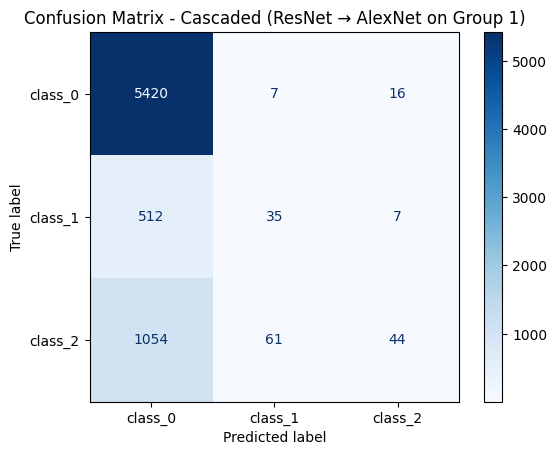

In [ ]:
cm = confusion_matrix(y_true_alexnet_g1, y_pred_alexnet_g1, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=group1_class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Cascaded (ResNet → AlexNet on Group 1)")
plt.show()

In [ ]:
def build_mobilenetv2_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(3, activation="softmax")  # Group 1: class_0, class_1, class_2
    ])
    return model

# Compile model
mobilenet_model = build_mobilenetv2_model()
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = mobilenet_model.fit(
    group1_train_dataset,
    epochs=50,
    validation_data=group1_test_dataset,
    callbacks=[early_stopping]
)

mobilenet_model.save("mobilenetv2_group1.h5")

Epoch 1/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 77s 30ms/step - accuracy: 0.5177 - loss: 0.9705 - val_accuracy: 0.7133 - val_loss: 0.7996
Epoch 2/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.6067 - loss: 0.8214 - val_accuracy: 0.7187 - val_loss: 0.7919
Epoch 3/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.6353 - loss: 0.7785 - val_accuracy: 0.7242 - val_loss: 0.7769
Epoch 4/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.6488 - loss: 0.7528 - val_accuracy: 0.7319 - val_loss: 0.7590
Epoch 5/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.6702 - loss: 0.7242 - val_accuracy: 0.7461 - val_loss: 0.7466
Epoch 6/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.6860 - loss: 0.7003 - val_accuracy: 0.7449 - val_loss: 0.7456
Epoch 7/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.6994 - loss: 0.6834 - val_accuracy: 0.7510 - val_loss: 0.7240
Epoch 8/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7104 -

In [ ]:
def cascaded_predict_group1_mobilenet(resnet_model, mobilenet_model, test_dataset):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        resnet_preds = resnet_model.predict(images)
        resnet_pred_classes = np.argmax(resnet_preds, axis=1)

        labels_np = labels.numpy()
        group1_indices = np.where(np.isin(resnet_pred_classes, [0, 1, 2]))[0]

        if len(group1_indices) == 0:
            continue

        group1_images = tf.gather(images, group1_indices)
        group1_true_labels = labels_np[group1_indices]

        # MobileNetV2 predicts Group 1
        mobilenet_preds = mobilenet_model.predict(group1_images)
        mobilenet_pred_classes = np.argmax(mobilenet_preds, axis=1)

        y_true.extend(group1_true_labels)
        y_pred.extend(mobilenet_pred_classes)

    return np.array(y_true), np.array(y_pred)

# Run cascaded prediction
y_true_mobilenet_g1, y_pred_mobilenet_g1 = cascaded_predict_group1_mobilenet(
    resnet_model, mobilenet_model, combined_test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
# Evaluation report
group1_report = classification_report(
    y_true_mobilenet_g1,
    y_pred_mobilenet_g1,
    labels=[0, 1, 2],
    target_names=group1_class_names,
    output_dict=True
)

print("\n--- Classification Report (Group 1 Only, ResNet → MobileNetV2) ---")
print(classification_report(
    y_true_mobilenet_g1,
    y_pred_mobilenet_g1,
    labels=[0, 1, 2],
    target_names=group1_class_names
))

# Summary
overall_precision = group1_report['weighted avg']['precision']
overall_recall = group1_report['weighted avg']['recall']
overall_f1 = group1_report['weighted avg']['f1-score']

print(f"\nGroup 1 Overall Precision (Weighted Avg): {overall_precision:.4f}")
print(f"Group 1 Overall Recall    (Weighted Avg): {overall_recall:.4f}")
print(f"Group 1 Overall F1-Score  (Weighted Avg): {overall_f1:.4f}")


--- Classification Report (Group 1 Only, ResNet → MobileNetV2) ---
              precision    recall  f1-score   support

     class_0       0.76      0.98      0.86      5443
     class_1       0.26      0.04      0.06       554
     class_2       0.42      0.13      0.19      1159

   micro avg       0.74      0.77      0.75      7156
   macro avg       0.48      0.38      0.37      7156
weighted avg       0.67      0.77      0.69      7156


Group 1 Overall Precision (Weighted Avg): 0.6675
Group 1 Overall Recall    (Weighted Avg): 0.7655
Group 1 Overall F1-Score  (Weighted Avg): 0.6869


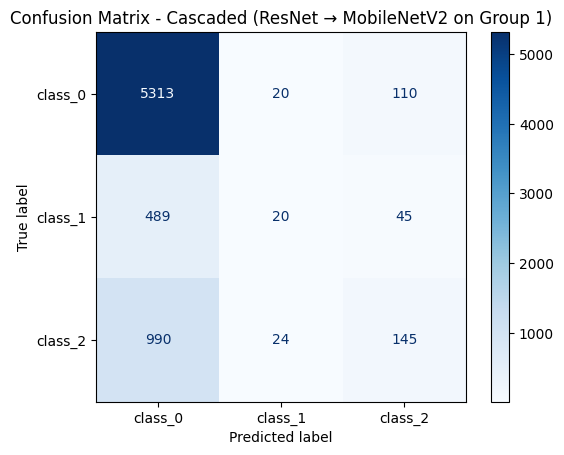

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true_mobilenet_g1, y_pred_mobilenet_g1, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=group1_class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Cascaded (ResNet → MobileNetV2 on Group 1)")
plt.show()

In [ ]:
def build_resnet50_group1_model():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(3, activation="softmax")  # Group 1: class 0, 1, 2
    ])
    return model

resnet_group1_model = build_resnet50_group1_model()
resnet_group1_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            loss="sparse_categorical_crossentropy",
                            metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = resnet_group1_model.fit(
    group1_train_dataset,
    epochs=50,
    validation_data=group1_test_dataset,
    callbacks=[early_stopping]
)

resnet_group1_model.save("resnet50_group1.h5")

Epoch 1/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 72s 29ms/step - accuracy: 0.5240 - loss: 0.9700 - val_accuracy: 0.6309 - val_loss: 0.8790
Epoch 2/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.6098 - loss: 0.8456 - val_accuracy: 0.6433 - val_loss: 0.8577
Epoch 3/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.6439 - loss: 0.7837 - val_accuracy: 0.6659 - val_loss: 0.8218
Epoch 4/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.6734 - loss: 0.7357 - val_accuracy: 0.6425 - val_loss: 0.8541
Epoch 5/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.6952 - loss: 0.6967 - val_accuracy: 0.6618 - val_loss: 0.8288
Epoch 6/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.7130 - loss: 0.6680 - val_accuracy: 0.6982 - val_loss: 0.7672
Epoch 7/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.7340 - loss: 0.6324 - val_accuracy: 0.6696 - val_loss: 0.8115
Epoch 8/50
2072/2072 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.7476 -

In [ ]:
def cascaded_predict_group1_resnet(resnet_model_round1, resnet_model_group1, test_dataset):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        resnet_preds = resnet_model_round1.predict(images)
        resnet_pred_classes = np.argmax(resnet_preds, axis=1)

        labels_np = labels.numpy()
        group1_indices = np.where(np.isin(resnet_pred_classes, [0, 1, 2]))[0]

        if len(group1_indices) == 0:
            continue

        group1_images = tf.gather(images, group1_indices)
        group1_true_labels = labels_np[group1_indices]

        # Predict with ResNet specialized for Group 1
        resnet_group1_preds = resnet_model_group1.predict(group1_images)
        resnet_group1_pred_classes = np.argmax(resnet_group1_preds, axis=1)

        y_true.extend(group1_true_labels)
        y_pred.extend(resnet_group1_pred_classes)

    return np.array(y_true), np.array(y_pred)

# Run cascaded prediction
y_true_resnet_g1, y_pred_resnet_g1 = cascaded_predict_group1_resnet(
    resnet_model, resnet_group1_model, combined_test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━

In [ ]:
# Classification Report
group1_report = classification_report(
    y_true_resnet_g1,
    y_pred_resnet_g1,
    labels=[0, 1, 2],
    target_names=group1_class_names,
    output_dict=True
)

print("\n--- Classification Report (Group 1 Only, ResNet → ResNet) ---")
print(classification_report(
    y_true_resnet_g1,
    y_pred_resnet_g1,
    labels=[0, 1, 2],
    target_names=group1_class_names
))

overall_precision = group1_report['weighted avg']['precision']
overall_recall = group1_report['weighted avg']['recall']
overall_f1 = group1_report['weighted avg']['f1-score']

print(f"\nGroup 1 Overall Precision (Weighted Avg): {overall_precision:.4f}")
print(f"Group 1 Overall Recall    (Weighted Avg): {overall_recall:.4f}")
print(f"Group 1 Overall F1-Score  (Weighted Avg): {overall_f1:.4f}")



--- Classification Report (Group 1 Only, ResNet → ResNet) ---
              precision    recall  f1-score   support

     class_0       0.78      0.84      0.81      5443
     class_1       0.13      0.10      0.12       554
     class_2       0.33      0.31      0.32      1159

   micro avg       0.68      0.70      0.69      7156
   macro avg       0.41      0.42      0.42      7156
weighted avg       0.66      0.70      0.68      7156


Group 1 Overall Precision (Weighted Avg): 0.6584
Group 1 Overall Recall    (Weighted Avg): 0.6991
Group 1 Overall F1-Score  (Weighted Avg): 0.6778


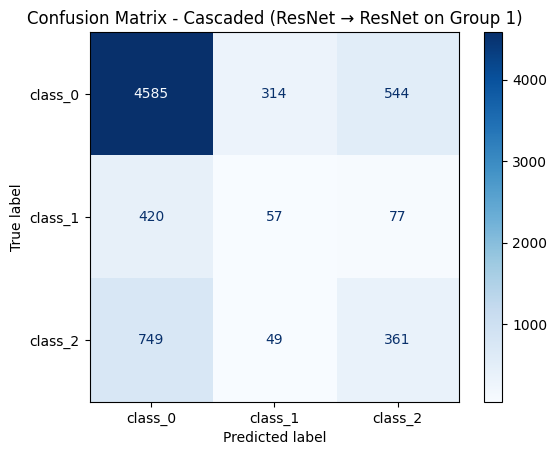

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true_resnet_g1, y_pred_resnet_g1, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=group1_class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Cascaded (ResNet → ResNet on Group 1)")
plt.show()